In [1]:
import os
import itertools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [2]:
#background image to be used
img = Image.open('maps/map_detailed_723.jpeg')

In [3]:
class Ward:
    def __init__(self, df):
        """
        Performs queries over a warding dataframe.
        """
        #load dataframe
        self.df = df
        
        #get the columns associated with a building dire/radiant
        self.bldg_cols = [col for col in self.df
                          if ('dire_' in col)
                          or ('radiant_' in col)]
        
        #get the columns associated with Rosh
        self.rosh_cols = [col for col in self.df
                         if 'rosh' in col.lower()]
        
        self.__TimeCols = list(itertools.chain(['time'], self.rosh_cols, self.bldg_cols))
        
        
        #lower left corner translated (64,64)-->(0,0)        
        self.df['x'] = self.df['x'] - 64
        self.df['y'] = self.df['y'] - 64
        

        self.__maxTimePossible= 3*60*60
        #fill nans
        self.df[self.bldg_cols] = self.df[self.bldg_cols].fillna(value=self.__maxTimePossible)
        self.df[self.rosh_cols] = self.df[self.rosh_cols].fillna(value=self.__maxTimePossible)
        
        #create a reduced dataframe for later use
        self.df_filter = self.df.copy(deep=True)
        
    def resetFilters(self):
        """
        resets the filtered dataframe to the original data in place
        """
        self.df_filter = self.df
        
    
    
    def _filterByTowers(self, 
                        df,
                        is_radiant=True,
                        lane='top', 
                        tower_number=0):
        """
        Returns dataframe where given tower is alive based on user criteria
        Parameters
        ----------
        df: pandas
            Dataframe containing data.
        
        is_radiant: Bool, default=True
                    True if Radiant and False if Dire.
                    
        lane: string, default='top'
              The lane, can only be ('top', 'mid', 'bot')  
        
        tower_num: integer, default= None
                   The tower number that was most recently taken. Can only be 0,1,2,3 such that zero means no objectives were taken. 
                   1 means that tower 1 is taken, etc...
        
        
        """

        #check for input on tower number
        if not (0 <= tower_number <= 3):
            raise ValueError(f'The number entered can only be (0,1,2,3)')
        #check for input on lane
        if lane not in ['top', 'mid', 'bot']:
            raise ValueError('Only allowed inputs are ("top", "mid", "bot")')
            
        
        
        #prepare query column
        if is_radiant:
            side = 'radiant_tower'
        else:
            side = 'dire_tower'
            
        
        
        #if tower tower number is 0 then tower is alive at time of planting
        # filter based on
        if tower_number == 0:
            col = ''.join([side,
                           '1',
                           '_', 
                           lane]
                         )
            #return wards planted BEFORE death of corresponding tier 1 tower
            return df.query(f'time < {col}')
        
        
        #if tower number less than 3 get times in between
        if tower_number <3:
            col_lower = ''.join([side,
                           str(tower_number),
                           '_', 
                           lane]
                         )
            
            col_upper = ''.join([side,
                           str(tower_number+1),
                           '_', 
                           lane]
                         )
            
            return df.query(f'{col_upper} > time > {col_lower}')
        
        
        col = ''.join([side,
                       str(tower_number),
                       '_', 
                       lane]
                     )
        
        #return wards planted after death of building
        return df.query(f'time > {col}')
        
            
    def getFilteredTowers(self, 
                        radiant_top=0, 
                        radiant_mid=0, 
                        radiant_bot=0, 
                        dire_top=0, 
                        dire_mid=0, 
                        dire_bot=0):
        """
        modifies filter dataframe for last surviving tier tower in all lanes. 
        Let 0 denote that the tower is still alive. Any number greater than 0 means that this tower is destroyed.
        ----------
        radiant_top: integer, default=0
                    Last destroyed tower in radiant top lane
        radiant_mid: integer, default=0
                    Last destroyed tower in radiant mid lane
        radiant_bot: integer, default=0
                    Last destroyed tower in radiant bot lane
        dire_top: integer, default=0
                    Last destroyed tower in dire top lane
        dire_mid: integer, default=0
                    Last destroyed tower in dire mid lane
        dire_bot: integer, default=0
                    Last destroyed tower in dire bot lane
    
        """
        
        #make a deep copy of existing filtered df
        df_filter = self.df_filter.copy(deep=True)
        
        #for radiant top towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=True,
                                         lane='top',
                                         tower_number = radiant_top)
        #for radiant mid towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=True,
                                         lane='mid',
                                         tower_number = radiant_mid)
        #for radiant bot towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=True,
                                         lane='bot',
                                         tower_number = radiant_bot)
        #for dire top towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=False,
                                         lane='top',
                                         tower_number = dire_top)
        #for dire mid towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=False,
                                         lane='mid',
                                         tower_number = dire_mid)
        #for dire bot towers
        df_filter = self._filterByTowers(df = df_filter, 
                                         is_radiant=False,
                                         lane='bot',
                                         tower_number = dire_bot)
        
        
        self.df_filter = df_filter

        
        
        def  _filterByCreepBldg(self, 
                                is_alive=True,
                                df=None,
                                is_radiant=True,
                                lane='top', 
                                kind='melee'):
            """
            Returns dataframe where given rax/ranged building is alive/dead based on user criteria.
            Parameters
            ----------
            df: pandas
                Dataframe containing data.

            is_radiant: Bool, default=True
                        True if Radiant and False if Dire.

            lane: string, default='top'
                  The lane, can only be ('top', 'mid', 'bot')  

            is_melee: Bool, default= True
                       If melee or ranged


            """

            #check for input on lane
            if lane not in ['top', 'mid', 'bot']:
                raise ValueError('Only allowed inputs are ("top", "mid", "bot")')
            #check for input on kind
            if kind not in ['melee', 'range']:
                raise ValueError('Only allowed inputs are ("melee", "range")')

            #radiant_range_rax_top
            #radiant_melee_rax_mid
            
            #if still alive then do nothing
            if is_alive:
                return df
            #if no argument given for df do nothing
            if df is None:
                pass


            #prepare query column
            if is_radiant:
                side = 'radiant'
            else:
                side = 'dire'

            col = ''.join([side,
                           kind,
                           '_', 
                           lane]
                         )
            #if tower is alive at time of ward then no query needed
            if tower_number == 0:
                return df

            #return wards planted after death of building
            return df.query(f'time > {col}')

    
    
    def getFilteredRax(self, 
                        radiant_top=True, 
                        radiant_mid=True, 
                        radiant_bot=True, 
                        dire_top=True, 
                        dire_mid=True, 
                        dire_bot=True):
        
        df_filter = self.df_filter.copy(deep=True)
        
        #for radiant top towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_top,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='top',
                                         kind = 'melee')
        #for radiant mid towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_mid,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='mid',
                                         kind = 'melee')
        #for radiant bot towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_bot,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='bot',
                                         kind = 'melee')
        #for dire top towers
        df_filter = self._filterByCreepBldg(is_alive=dire_top,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='top',
                                         kind = 'melee')
        #for dire mid towers
        df_filter = self._filterByCreepBldg(is_alive=dire_mid,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='mid',
                                         kind = 'melee')
        #for dire bot towers
        df_filter = self._filterByCreepBldg(is_alive=dire_bot,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='bot',
                                         kind = 'melee')
        
        
        self.df_filter = df_filter
        #return the filtered dataframe
        return self.df_filter
    
    
    def getFilteredRanged(self, 
                        radiant_top=True, 
                        radiant_mid=True, 
                        radiant_bot=True, 
                        dire_top=True, 
                        dire_mid=True, 
                        dire_bot=True):
        
        df_filter = self.df.copy(deep=True)
        
        #for radiant top towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_top,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='top',
                                         kind = 'range')
        #for radiant mid towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_mid,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='mid',
                                         kind = 'range')
        #for radiant bot towers
        df_filter = self._filterByCreepBldg(is_alive=radiant_bot,
                                            df = df_filter, 
                                         is_radiant=True,
                                         lane='bot',
                                         kind = 'range')
        #for dire top towers
        df_filter = self._filterByCreepBldg(is_alive=dire_top,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='top',
                                         kind = 'range')
        #for dire mid towers
        df_filter = self._filterByCreepBldg(is_alive=dire_mid,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='mid',
                                         kind = 'range')
        #for dire bot towers
        df_filter = self._filterByCreepBldg(is_alive=dire_bot,
                                            df = df_filter, 
                                         is_radiant=False,
                                         lane='bot',
                                         kind = 'range')
        
        
        self.df_filter = df_filter
        #return the filtered dataframe
        return self.df_filter
        
    

## Observer Wards

In [4]:
obs_path = 'df_obs_obj.csv'
df = pd.read_csv(obs_path)

wards = Ward(df)

wards.df.shape

(154502, 50)

In [5]:
wards.df.head()

,match_id,start_time,hero_id,time,x,y,z,is_radiant,dire_tower1_top,radiant_tower1_bot,...,radiant_range_rax_top,radiant_tower4,radiant_fort,ROSHAN_2,dire_tower4,ROSHAN_3,ROSHAN_4,ROSHAN_5,ROSHAN_6,ROSHAN_7
0,5972747514,2021-05-01 04:06:13,103,365,84,38,132,1,550.0,553.0,...,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0
1,5972747514,2021-05-01 04:06:13,103,592,68,30,130,1,550.0,553.0,...,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0
2,5972747514,2021-05-01 04:06:13,103,778,58,78,132,1,550.0,553.0,...,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0
3,5972747514,2021-05-01 04:06:13,103,1042,42,90,132,1,550.0,553.0,...,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0
4,5972747514,2021-05-01 04:06:13,103,1194,74,92,130,1,550.0,553.0,...,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0,10800.0


### Sample Case
- radiant top: tier 1 ALIVE
- radiant mid: tier 1 DEAD
- radiant bot: tier 1 ALIVE
- dire top: tier 1 ALIVE
- dire mid: tier 1 DEAD
- dire bot: tier 1 DEAD

In [6]:
#flush out any changes before this code block
wards.resetFilters()

wards.getFilteredTowers(radiant_top=0, #tower lives 
                        radiant_mid=0, #tier 1 dead
                        radiant_bot=1, # tower lives
                        dire_top=1, #tier 1 alive
                        dire_mid=1, #tier 1 dead
                        dire_bot=1 #tier 1 dead
                       )

#what % is left?
wards.df_filter.shape[0]

1704

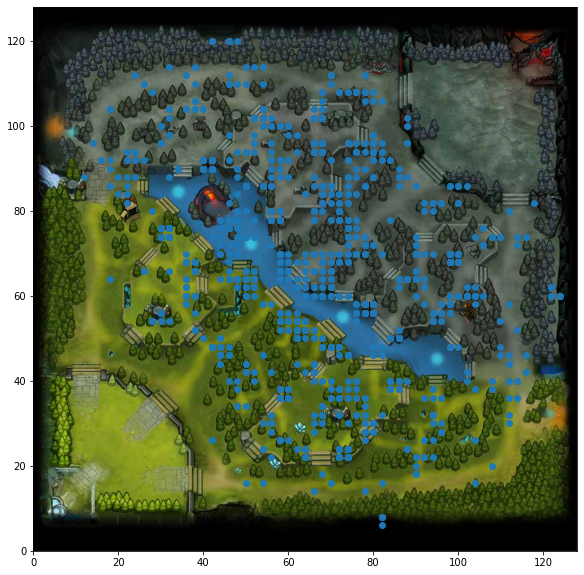

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.scatter(wards.df_filter['x'], wards.df_filter['y'])
axs.imshow(img, extent=[0, 128, 0, 128])


In [8]:
wards.df_filter[['x', 'y','time', 'radiant_tower1_top', 'radiant_tower2_top']]

,x,y,time,radiant_tower1_top,radiant_tower2_top
248,78,28,873,1347.0,10800.0
249,32,74,1020,1347.0,10800.0
250,114,40,1064,1347.0,10800.0
251,52,62,1156,1347.0,10800.0
269,62,54,946,1347.0,10800.0
...,...,...,...,...,...
153593,68,94,884,10800.0,10800.0
153594,72,46,1010,10800.0,10800.0
153603,98,48,944,10800.0,10800.0
153609,68,50,912,10800.0,10800.0
